<a href="https://colab.research.google.com/github/mchchoi/permutation/blob/main/Edwards-Anderson/EA_adaptive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Figure size 1400x600 with 0 Axes>

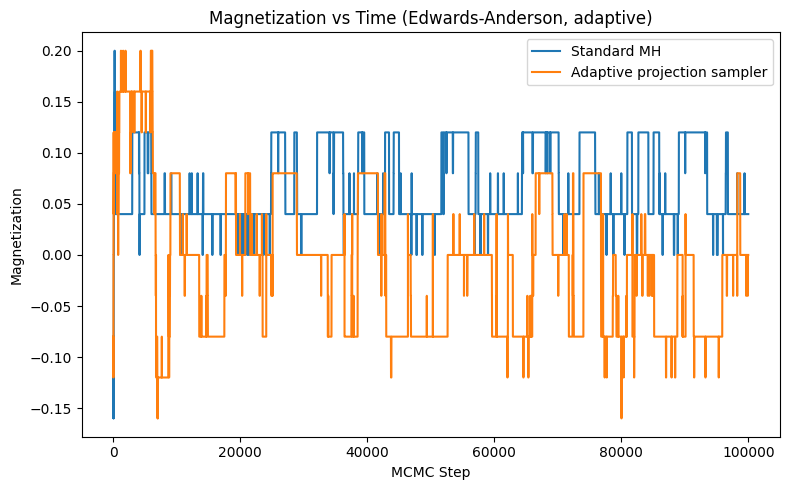

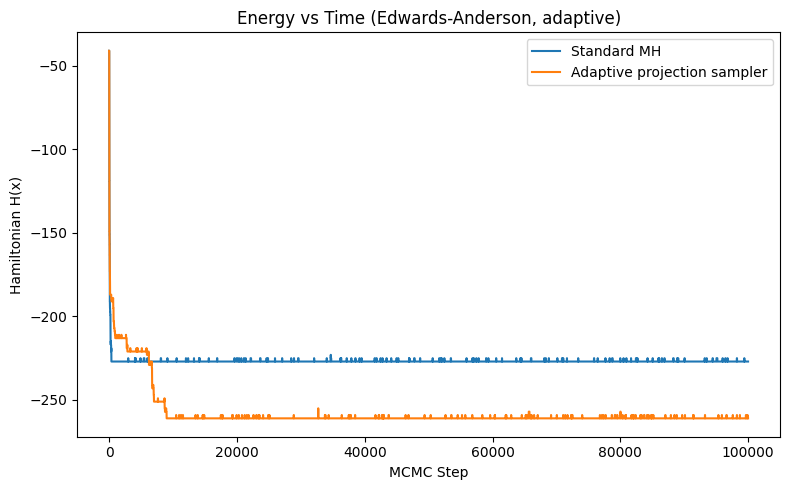

In [1]:
import numpy as np
import matplotlib.pyplot as plt

d = 50                 # Number of spins
n_steps = 100000        # Number of MCMC steps
beta = 2             # Inverse temperature

np.random.seed(40)

# --- Generate ±J Couplings ---
J = np.random.choice([-1, 1], size=(d, d))
J = np.triu(J, 1)
J += J.T
np.fill_diagonal(J, 0)

# --- Hamiltonian for ±J Spin Glass ---
def hamiltonian(x):
    return -0.5 * np.sum(J * np.outer(x, x))

def metropolis_step(x):
    """One step of standard Metropolis-Hastings for the Ising model.
       Propose flipping one random spin and accept with probability min(1, exp(-ΔH))."""
    x_new = x.copy()
    i = np.random.randint(0, d)
    x_new[i] *= -1
    delta_H = hamiltonian(x_new) - hamiltonian(x)
    if np.random.rand() < np.exp(-beta * delta_H):
        return x_new
    else:
        return x

# Apply permutation Q_psi
def Q_psi(x, psi):
    key = x.tobytes()
    return psi[key].copy() if key in psi else x.copy()

# Efficient update of the adaptive permutation psi
def update_psi_efficient(psi, history, energy_history, update_interval=50):
    if len(history) % update_interval == 0:
        # Select a random pair of states with matching energy to update the permutation
        energy_to_states = {}
        for i, energy in enumerate(energy_history):
            if energy not in energy_to_states:
                energy_to_states[energy] = []
            energy_to_states[energy].append(history[i])

        # Find matching energy states and update permutation if necessary
        for energy, states in energy_to_states.items():
            if len(states) > 1:
                i, j = np.random.choice(len(states), 2, replace=False)
                x_i = states[i]
                x_j = states[j]
                xi_key, xj_key = x_i.tobytes(), x_j.tobytes()

                if xi_key not in psi and xj_key not in psi:
                    psi[xi_key] = x_j
                    psi[xj_key] = x_i
                    break

# Adaptive projection step
def metropolis_step_adaptive_projection(x, psi):
    y1 = metropolis_step(x)
    y2 = Q_psi(metropolis_step(Q_psi(x, psi)), psi)
    return y1 if np.random.rand() < 0.5 else y2

# Magnetization
def magnetization(x):
    return np.mean(x)

# Initialization
state_std = np.random.choice([-1, 1], size=d)
#state_std = np.ones(d, dtype=int)
state_mod = state_std.copy()
mag_std = np.zeros(n_steps)
mag_mod = np.zeros(n_steps)
energy_std = np.zeros(n_steps)
energy_mod = np.zeros(n_steps)
psi = {}
history = []
energy_history = []

# Run both standard MH and adaptive sampler
for t in range(n_steps):
    state_std = metropolis_step(state_std)  # Standard MH step
    state_mod = metropolis_step_adaptive_projection(state_mod, psi)  # Adaptive step

    mag_std[t] = magnetization(state_std)
    mag_mod[t] = magnetization(state_mod)
    energy_std[t] = hamiltonian(state_std)
    energy_mod[t] = hamiltonian(state_mod)

    # Record history and update psi for adaptive sampler
    history.append(state_mod.copy())
    energy_history.append(energy_mod[t])
    update_psi_efficient(psi, history, energy_history)

# Plot results
plt.figure(figsize=(14, 6))

# Magnetization plot
plt.figure(figsize=(8, 5))
plt.plot(mag_std, label='Standard MH')
plt.plot(mag_mod, label='Adaptive projection sampler')
plt.xlabel('MCMC Step')
plt.ylabel('Magnetization')
plt.title('Magnetization vs Time (Edwards-Anderson, adaptive)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('EA_magnetization_adaptive.png')
plt.show()

# Hamiltonian plot
plt.figure(figsize=(8, 5))
plt.plot(energy_std, label='Standard MH')
plt.plot(energy_mod, label='Adaptive projection sampler')
plt.xlabel('MCMC Step')
plt.ylabel('Hamiltonian H(x)')
plt.title('Energy vs Time (Edwards-Anderson, adaptive)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('EA_energy_adaptive.png')
plt.show()

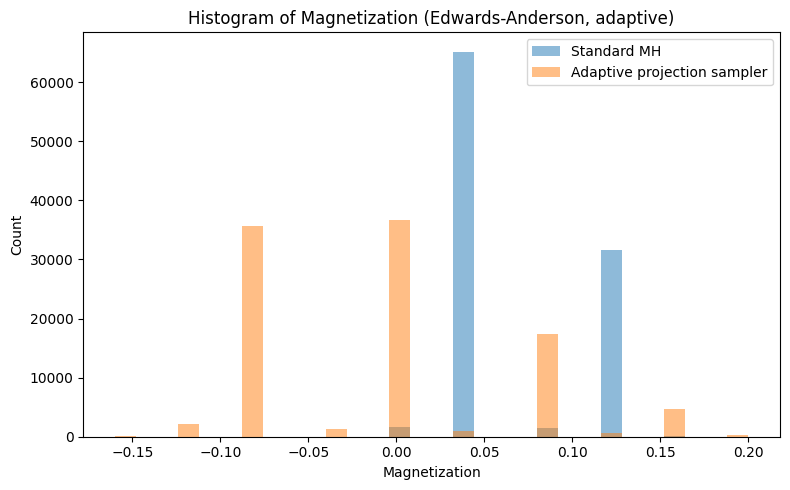

In [2]:
plt.figure(figsize=(8, 5))
plt.hist(mag_std[-100000:], bins=30, alpha=0.5, label='Standard MH', density=False)
plt.hist(mag_mod[-100000:], bins=30, alpha=0.5, label='Adaptive projection sampler', density=False)
plt.xlabel('Magnetization')
plt.ylabel('Count')
plt.title('Histogram of Magnetization (Edwards-Anderson, adaptive)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('EA_histogram_adaptive.png')
plt.show()

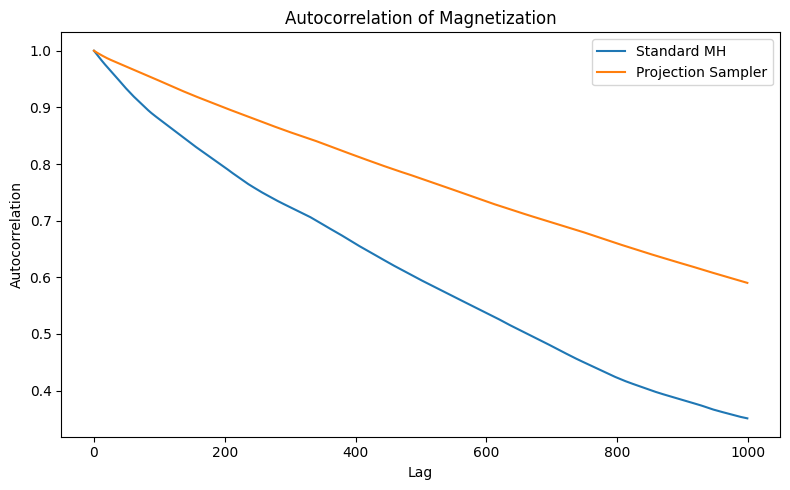

In [3]:
def autocorr(x, max_lag=1000):
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    result = result[result.size // 2:]
    return result[:max_lag] / result[0]

max_lag = 1000
ac_std = autocorr(mag_std, max_lag)
ac_mod = autocorr(mag_mod, max_lag)

plt.figure(figsize=(8, 5))
plt.plot(ac_std, label='Standard MH')
plt.plot(ac_mod, label='Projection Sampler')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Magnetization')
plt.legend()
plt.tight_layout()
plt.savefig('ising_autocorrelation.png')
plt.show()

In [4]:
def average_jump_distance(mag_series):
    """
    Computes the average one-step jump distance of magnetization.

    Parameters:
        mag_series (np.ndarray): Array of magnetization values over time.

    Returns:
        float: Average jump distance.
    """
    diffs = np.abs(np.diff(mag_series))
    return np.mean(diffs)

jump_std = average_jump_distance(mag_std)
jump_mod = average_jump_distance(mag_mod)

print(f"Average jump distance (Standard MH): {jump_std:.5f}")
print(f"Average jump distance (Projection MH): {jump_mod:.5f}")

Average jump distance (Standard MH): 0.00010
Average jump distance (Projection MH): 0.00015


In [5]:
import numpy as np
from scipy.stats import norm

def compute_summary_stats(samples, name=""):
    samples = np.asarray(samples)
    mean = np.mean(samples)
    var = np.var(samples, ddof=1)  # Sample variance
    n = len(samples)

    # Estimate ESS
    def compute_ess(trace):
        n = len(trace)
        trace = trace - np.mean(trace)
        acov = np.correlate(trace, trace, mode='full')[n-1:] / np.arange(n, 0, -1)
        acov /= acov[0]
        cutoff = np.where(acov < 0)[0]
        cutoff = cutoff[0] if len(cutoff) > 0 else n
        tau = 1 + 2 * np.sum(acov[1:cutoff])
        return n / tau

    ess = compute_ess(samples)

    # Standard error and 95% CI
    std_err = np.sqrt(var / ess)
    z = norm.ppf(0.975)  # For 95% CI
    ci_low, ci_high = mean - z * std_err, mean + z * std_err

    print(f"--- {name} ---")
    print(f"Sample mean     : {mean:.6f}")
    print(f"Sample variance : {var:.6f}")
    print(f"ESS             : {ess:.2f}")
    print(f"95% CI          : [{ci_low:.6f}, {ci_high:.6f}]\n")

# Run this after MCMC loop
compute_summary_stats(mag_std, name="Standard MH")
compute_summary_stats(mag_mod, name="Projection sampler")

--- Standard MH ---
Sample mean     : 0.065232
Sample variance : 0.001458
ESS             : 52.05
95% CI          : [0.054859, 0.075605]

--- Projection sampler ---
Sample mean     : -0.008540
Sample variance : 0.005122
ESS             : 35.11
95% CI          : [-0.032212, 0.015131]



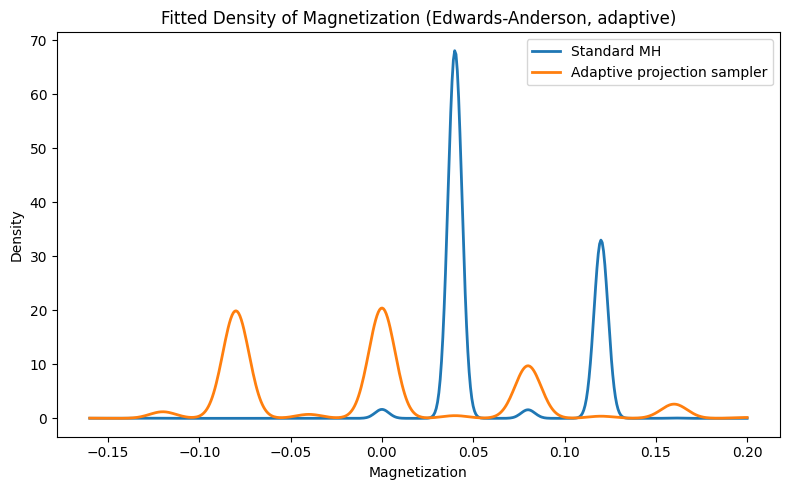

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# Compute KDEs
kde_std = gaussian_kde(mag_std)
kde_proj = gaussian_kde(mag_mod)

x_vals = np.linspace(min(np.min(mag_std), np.min(mag_mod)),
                     max(np.max(mag_std), np.max(mag_mod)), 500)

# Plot histograms with density=True and overlay KDE curves
plt.figure(figsize=(8, 5))
#plt.hist(mag_std, bins=30, alpha=0.4, label='Standard MH', density=True)
#plt.hist(mag_mod, bins=30, alpha=0.4, label='Adaptive projection sampler', density=True)

plt.plot(x_vals, kde_std(x_vals), lw=2, label='Standard MH')
plt.plot(x_vals, kde_proj(x_vals), lw=2, label='Adaptive projection sampler')

plt.xlabel('Magnetization')
plt.ylabel('Density')
plt.title('Fitted Density of Magnetization (Edwards-Anderson, adaptive)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('EA_histogram_density_adaptive.png')
plt.show()